In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from esig import tosig
from sklearn.utils import resample
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.multioutput import MultiOutputRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit


# Suppress convergence warnings from Lasso
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# --- Signature Computation ---
def compute_signature(path, order):
    """
    Computes the signature of a given path up to a specified order.

    Args:
        path (np.ndarray): The input path, typically a 2D array where rows are
                           points and columns are dimensions (e.g., [time, value]).
        order (int): The maximum signature order to compute.

    Returns:
        np.ndarray: The signature of the path as a 1D numpy array.
    """
    return tosig.stream2sig(path, order)


# --- Bootstrap Lasso (for multi-output) ---
def bootstrap_lasso(X, y, num_bootstrap_samples=200, alpha=0.0001):
    """
    Performs bootstrap resampling to estimate the coefficients and their
    confidence intervals for a MultiOutputRegressor (Lasso).

    Args:
        X (np.ndarray): The input features.
        y (np.ndarray): The target variables (multi-output).
        num_bootstrap_samples (int): The number of bootstrap samples to generate.
        alpha (float): The regularization strength for Lasso.

    Returns:
        tuple: A tuple containing:
            - coef_means (np.ndarray): Mean coefficients across bootstrap samples.
            - coef_stds (np.ndarray): Standard deviation of coefficients.
            - intercept_mean (np.ndarray): Mean intercepts.
            - intercept_std (np.ndarray): Standard deviation of intercepts.
            - coefs (np.ndarray): All sampled coefficients.
            - intercepts (np.ndarray): All sampled intercepts.
            - lower_bounds (np.ndarray): 2.5th percentile (lower bound of 95% CI).
            - upper_bounds (np.ndarray): 97.5th percentile (upper bound of 95% CI).
    """
    n_targets = y.shape[1]
    n_features = X.shape[1]
    
    coefs = np.zeros((num_bootstrap_samples, n_features, n_targets))
    intercepts = np.zeros((num_bootstrap_samples, n_targets))

    for i in range(num_bootstrap_samples):
        # Resample with replacement
        X_resampled, y_resampled = resample(X, y, random_state=i) # Added random_state for reproducibility
        lasso = MultiOutputRegressor(Lasso(alpha=alpha, random_state=i)) # Added random_state
        lasso.fit(X_resampled, y_resampled)
        
        for target_idx, estimator in enumerate(lasso.estimators_):
            coefs[i, :, target_idx] = estimator.coef_
            intercepts[i, target_idx] = estimator.intercept_

    coef_means = np.mean(coefs, axis=0)
    coef_stds = np.std(coefs, axis=0)
    lower_bounds = np.percentile(coefs, 2.5, axis=0)
    upper_bounds = np.percentile(coefs, 97.5, axis=0)
    intercept_mean = np.mean(intercepts, axis=0)
    intercept_std = np.std(intercepts, axis=0)

    return coef_means, coef_stds, intercept_mean, intercept_std, coefs, intercepts, lower_bounds, upper_bounds


# --- ES Calibration Function ---
def ES_calibration(data, expected_data, p, q, n, m, demean=True, additional_features=None):
    """
    Performs Event-Series (ES) calibration by computing signatures of past and future
    paths and training a Lasso model to predict future signatures from past ones.

    Args:
        data (np.ndarray): The main time series data.
        expected_data (np.ndarray): The expected future data (shifted main data).
        p (int): Length of the past path window.
        q (int): Length of the future path window (typically 1 for next step).
        n (int): Signature depth for past paths.
        m (int): Signature depth for future paths.
        demean (bool): Whether to demean the paths by their base value.
        additional_features (pd.DataFrame, optional): Additional features to concatenate
                                                     with the past signature.

    Returns:
        tuple: A tuple containing:
            - y_test_real (np.ndarray): Actual future values for testing.
            - y_test_exp (np.ndarray): Expected future values for testing.
            - yhat_test (np.ndarray): Predicted future values for testing.
            - running_time (float): Time taken for the calibration process.
            - X_sig_train (np.ndarray): Scaled past signatures for training.
            - y_sig_train_component (np.ndarray): Scaled 3rd component of future signatures for training.
            - lasso (MultiOutputRegressor): The trained Lasso model.
            - X_sig_test (np.ndarray): Scaled past signatures for testing.
            - scaler_y (StandardScaler): The scaler fitted on future signatures.
            - train_size_es (int): The size of the training set used for ES calibration.
    """
    starting_time = time.time()

    X_sig, y_sig = [], []

    # Iterate through the data to create past and future path windows
    for t in range(p, len(data) - q):
        base_value = data[t - 1]

        # --- Constructing Past path ---
        past_values = data[t - p: t + 1]
        if demean:
            past_values = past_values - base_value
        else:
            past_values = np.insert(past_values, 0, 0)
        
        time_steps = np.linspace(0, 1, len(past_values))
        past_path = np.column_stack((time_steps, past_values))

        past_path_with_time = []
        for i in range(len(past_path) - 1):
            start_time, start_value = past_path[i]
            end_time, _ = past_path[i + 1]
            past_path_with_time.append([start_time, start_value])
            past_path_with_time.append([end_time, start_value])
        past_path_with_time.append(past_path[-1].tolist())
        past_path_with_time = np.array(past_path_with_time)

        past_signature = compute_signature(past_path_with_time, n)

        # --- Constructing Future path ---
        future_values = np.array([0, data[t] - base_value, data[t + 1] - base_value])
        future_times = np.linspace(0, 1, len(future_values))
        future_path = np.column_stack((future_times, future_values))

        future_path_with_time = []
        for i in range(len(future_path) - 1):
            start_time, start_value = future_path[i]
            end_time, _ = future_path[i + 1]
            future_path_with_time.append([start_time, start_value])
            future_path_with_time.append([end_time, start_value])
        future_path_with_time.append(future_path[-1].tolist())
        future_path_with_time = np.array(future_path_with_time)

        future_signature = compute_signature(future_path_with_time, m)

        # --- Add additional features if provided ---
        if additional_features is not None:
            extra_feat = additional_features.iloc[t - p].values
            past_signature = np.concatenate((past_signature, extra_feat))

        X_sig.append(past_signature)
        y_sig.append(future_signature)

    X_sig = np.array(X_sig)
    y_sig = np.array(y_sig)

    # --- Data Splitting ---
    train_size_es = int(0.8 * len(X_sig)) # Store this for naive benchmark
    X_sig_train_raw, y_sig_train_raw = X_sig[:train_size_es], y_sig[:train_size_es]
    X_sig_test_raw, y_sig_test_raw = X_sig[train_size_es:], y_sig[train_size_es:]

    # --- Imputation ---
    imputer_X = SimpleImputer(strategy='mean')
    X_sig_train = imputer_X.fit_transform(X_sig_train_raw)
    X_sig_test = imputer_X.transform(X_sig_test_raw) 

    # --- Scaling ---
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    
    X_sig_train = scaler_x.fit_transform(X_sig_train)
    y_sig_train = scaler_y.fit_transform(y_sig_train_raw)

    X_sig_test = scaler_x.transform(X_sig_test)
    y_sig_test = scaler_y.transform(y_sig_test_raw) 

    # --- Model Training ---
    lasso = MultiOutputRegressor(Lasso(alpha=0.001, random_state=42)) 
    lasso.fit(X_sig_train, y_sig_train)

    # --- Prediction ---
    yhat_sig_test = lasso.predict(X_sig_test)

    # --- Inverse Transformation for Evaluation ---
    yhat_test = scaler_y.inverse_transform(yhat_sig_test)[:, 2]  
    y_test_exp = scaler_y.inverse_transform(y_sig_test)[:, 2]  
    y_test_real = scaler_y.inverse_transform(y_sig_test)[:, 2]

    ending_time = time.time()
    running_time = ending_time - starting_time

    return y_test_real, y_test_exp, yhat_test, running_time, X_sig_train, y_sig_train[:, 2], lasso, X_sig_test, scaler_y, train_size_es


def conformal_prediction_intervals(model, X_scaled, y_scaled_component, scaler_y, alpha=0.1, n_splits=5):
    """
    Calculates conformal prediction intervals for a single output component
    using a time series cross-validation split and the unscaled residuals.

    Args:
        model (sklearn estimator): The regression model to use (e.g., Lasso).
        X_scaled (np.ndarray): Scaled input features.
        y_scaled_component (np.ndarray): Scaled target component (e.g., y_sig_train[:, 2]).
        scaler_y (StandardScaler): The scaler fitted on the full multi-dimensional y_sig_train_raw.
        alpha (float): Significance level for the prediction interval (e.g., 0.1 for 90% PI).
        n_splits (int): Number of splits for TimeSeriesSplit cross-validation.

    Returns:
        float: The quantile value (q) used to construct the prediction intervals.
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    residuals_unscaled = []

    for train_index, val_index in tscv.split(X_scaled):
        X_train_scaled, X_val_scaled = X_scaled[train_index], X_scaled[val_index]
        y_train_scaled_comp, y_val_scaled_comp = y_scaled_component[train_index], y_scaled_component[val_index]

        if isinstance(model, MultiOutputRegressor):
            model_to_fit = MultiOutputRegressor(model.estimator) 
            model_to_fit.fit(X_train_scaled, y_train_scaled_comp.reshape(-1, 1))
            y_pred_scaled_comp = model_to_fit.predict(X_val_scaled).flatten() 
        else:
            model.fit(X_train_scaled, y_train_scaled_comp)
            y_pred_scaled_comp = model.predict(X_val_scaled)
        
        # Create dummy arrays to inverse transform single component
        y_val_full_scaled = np.zeros((len(y_val_scaled_comp), scaler_y.n_features_in_))
        y_val_full_scaled[:, 2] = y_val_scaled_comp
        y_val_unscaled = scaler_y.inverse_transform(y_val_full_scaled)[:, 2]

        y_pred_full_scaled = np.zeros((len(y_pred_scaled_comp), scaler_y.n_features_in_))
        y_pred_full_scaled[:, 2] = y_pred_scaled_comp
        y_pred_unscaled = scaler_y.inverse_transform(y_pred_full_scaled)[:, 2]

        residuals_unscaled.extend(np.abs(y_val_unscaled - y_pred_unscaled))

    q = np.quantile(residuals_unscaled, 1 - alpha)
    return q


# ---  Error Metric Functions ---

def calculate_scale_dependent_metrics(y_true, y_pred):
    """
    Calculates Mean Absolute Error (MAE), Mean Squared Error (MSE),
    and Root Mean Squared Error (RMSE).
    """
    errors = y_pred - y_true
    mae = np.mean(np.abs(errors))
    mse = np.mean(errors**2)
    rmse = np.sqrt(mse)
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse}

def calculate_forecast_bias_metrics(y_true, y_pred):
    """
    Calculates Mean Error (ME), Cumulative Forecast Error (CFE),
    and Tracking Signal (TS).
    """
    errors = y_pred - y_true
    me = np.mean(errors)
    cfe = np.sum(errors)
    
    # MAD is Mean Absolute Deviation of errors, which is MAE
    mad = np.mean(np.abs(errors))
    
    ts = np.nan
    if mad != 0:
        ts = cfe / mad
    
    return {'ME': me, 'CFE': cfe, 'MAD': mad, 'TS': ts}

def calculate_percentage_error_metrics(y_true, y_pred, epsilon=1e-10):
    """
    Calculates Mean Absolute Percentage Error (MAPE), Weighted Absolute Percentage Error (WAPE),
    Symmetric Mean Absolute Percentage Error (sMAPE), and Mean Arctangent Absolute Percentage Error (MAAPE).
    Adds a small epsilon to denominators to prevent division by zero.
    """
    errors = y_pred - y_true

    # MAPE
    # Avoid division by zero by adding epsilon
    mape = np.mean(np.abs(errors / (y_true + epsilon))) * 100

    # WAPE
    wape = (np.sum(np.abs(errors)) / (np.sum(np.abs(y_true)) + epsilon)) * 100

    # sMAPE
    smape = np.mean(np.abs(errors) / ((np.abs(y_true) + np.abs(y_pred)) / 2 + epsilon)) * 100

    # MAAPE
    maape = np.mean(np.arctan(np.abs(errors / (y_true + epsilon))))
    
    return {'MAPE': mape, 'WAPE': wape, 'sMAPE': smape, 'MAAPE': maape}

def calculate_naive_benchmark_errors(actual_data_segment):
    """
    Calculates errors for a naive forecast (previous value) on a given data segment.
    """
    if len(actual_data_segment) < 2:
        return np.array([])
    return actual_data_segment[1:] - actual_data_segment[:-1]

def calculate_scale_independent_metrics(y_true, y_pred, naive_errors_in_sample):
    """
    Calculates Mean Absolute Scaled Error (MASE) and Root Mean Squared Scaled Error (RMSSE).
    Requires in-sample naive forecast errors for scaling.
    """
    errors = y_pred - y_true
    
    mae_forecast = np.mean(np.abs(errors))
    rmse_forecast = np.sqrt(np.mean(errors**2))
    
    mae_naive_benchmark = np.mean(np.abs(naive_errors_in_sample))
    rmse_naive_benchmark = np.sqrt(np.mean(naive_errors_in_sample**2))
    
    mase = np.nan
    if mae_naive_benchmark != 0:
        mase = mae_forecast / mae_naive_benchmark
        
    rmsse = np.nan
    if rmse_naive_benchmark != 0:
        rmsse = rmse_forecast / rmse_naive_benchmark
        
    return {'MASE': mase, 'RMSSE': rmsse}

def calculate_fva(y_true, y_pred, naive_errors_test):
    """
    Calculates Forecast Value Added (FVA).
    Compares model MAE to naive benchmark MAE on the test set.
    """
    mae_model = np.mean(np.abs(y_pred - y_true))
    mae_naive_test_benchmark = np.mean(np.abs(naive_errors_test))
    
    fva = np.nan
    if mae_naive_test_benchmark != 0:
        fva = (1 - (mae_model / mae_naive_test_benchmark)) * 100
        
    return {'FVA': fva}


def plot_residuals(y_true, y_pred, title="Residuals (Actual - Predicted)"):
    """
    Plots the residuals of the forecast.
    """
    residuals = y_true - y_pred
    
    plt.figure(figsize=(12, 6))
    plt.plot(residuals, label='Residuals', color='red', alpha=0.7)
    plt.axhline(0, color='blue', linestyle='--', label='Zero Residual')
    plt.title(title)
    plt.xlabel('Time Step (Test Set Index)')
    plt.ylabel('Residual (Actual - Predicted)')
    plt.legend()
    plt.grid(True)
    plt.show()




/var/folders/42/y44rx7lj3l3_x781hgslxhhh0000gn/T/ipykernel_96739/28194600.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Realized_Volatility'] = np.sqrt(df['SPX2.rv'])
/opt/homebrew/Cellar/jupyterlab/4.3.5/libexec/lib/python3.13/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['SPX2.rcto']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Selected features: ['SPX2.rk', 'SPX2.r', 'SPX2.rv10', 'SPX2.rv10ss', 'SPX2.medrv', 'SPX2.rs', 'SPX2.nobs', 'SPX2.timespan', 'SPX2.highlow', 'SPX2.highopen', 'SPX2.closeprice', 'RV_Lag_1', 'RV_Lag_2', 'RV_Lag_3', 'RV_Lag_4', 'RV_Lag_5']


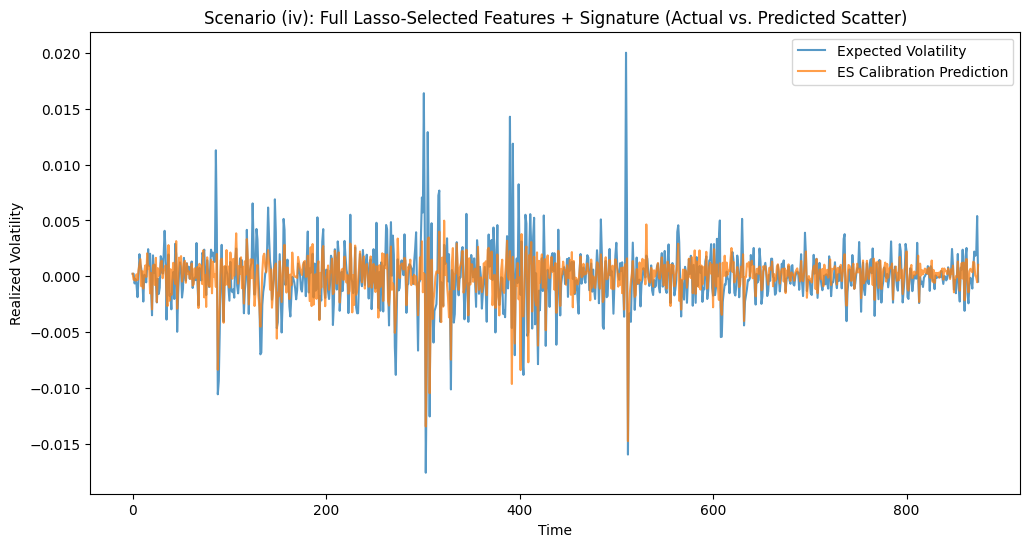

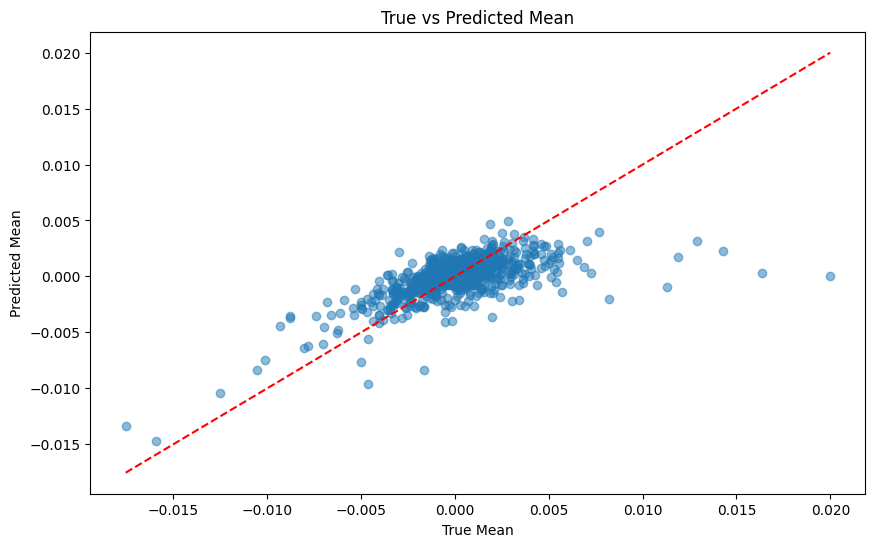

In [2]:

# Load and process data
df = pd.read_csv('old_OxfordManRealizedVolatilityIndices.csv', sep=",", header=2)
df_filtered = df.filter(regex='^SPX|^Date')
df_filtered['Realized_Volatility'] = np.sqrt(df['SPX2.rv'])
df2 = df_filtered.copy()
df2['DateID'] = pd.to_datetime(df2['DateID'], format='%Y%m%d')

# Remove outliers
def remove_outliers(data, column, threshold=3):
    z_scores = np.abs((data[column] - data[column].mean()) / data[column].std())
    return data[z_scores < threshold]
df2 = remove_outliers(df2, 'Realized_Volatility')

# Filter data by date (keeping the full range after outlier removal)
start_date = min(df2['DateID'])
end_date = max(df2['DateID'])
df2 = df2[(df2['DateID'] >= start_date) & (df2['DateID'] <= end_date)]


# Create lag features for 'Realized_Volatility'
for lag in range(1, 6):
    df2[f'RV_Lag_{lag}'] = df2['Realized_Volatility'].shift(lag)
# Prepare data for modeling

X = df2[[
    'SPX2.rk', 'SPX2.r', 'SPX2.rv5ss', 'SPX2.rv10', 'SPX2.rv10ss',
    'SPX2.bv5', 'SPX2.bv5ss', 'SPX2.medrv', 'SPX2.rs', 'SPX2.rs5ss',
    'SPX2.nobs', 'SPX2.timespan', 'SPX2.rcto', 'SPX2.open',
    'SPX2.highlow', 'SPX2.highopen', 'SPX2.openprice', 'SPX2.closeprice','RV_Lag_1'
    ,'RV_Lag_2','RV_Lag_3','RV_Lag_4','RV_Lag_5']]

y = df2['Realized_Volatility']

# Drop rows where X or y is NaN 
X = X[X.notna()]
y = y[y.notna()]

# Split X and y, respecting time for feature selection
train_size_fs = int(0.8 * len(X))
X_train_feat = X.iloc[:train_size_fs]
y_train_feat = y.iloc[:train_size_fs]

X_test_feat = X.iloc[train_size_fs:]
y_test_feat = y.iloc[train_size_fs:]

# Impute and scale training features only
imputer_fs = SimpleImputer(strategy='mean')
X_train_imp = imputer_fs.fit_transform(X_train_feat)

scaler_fs = StandardScaler()
X_train_scaled = scaler_fs.fit_transform(X_train_imp)

# LassoCV on training set only
lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_train_scaled, y_train_feat)

# Get selected features from the training set
selected_features_mask = lasso_cv.coef_ != 0
valid_columns_fs = X.columns[~np.isnan(imputer_fs.statistics_)]
selected_features = valid_columns_fs[selected_features_mask]
print(f"Selected features: {selected_features.tolist()}")

# Reduce full X (both train & test) using selected features
X_reduced = X[selected_features]


actual_data = y.values
expected_data = y.shift(-1).values

p = 20   # Consider the last 20 days for predictions
q = 1    # Predict next day's volatility
n = 4    # Signature depth for past data
m = 3    # Signature depth for future data

# Align reduced features to match the starting points of each signature window
X_reduced_aligned = X_reduced.iloc[p: len(actual_data) - q]  # must match X_sig length

y_test_real, y_test_exp, yhat_test, run_time, X_sig_train, y_sig_train_component, lasso_model, X_sig_test, scaler_y, train_size_es_cal = ES_calibration(
    actual_data, expected_data, p, q, n, m, demean=True, additional_features=X_reduced_aligned
)

# Remove NaN values from predictions and actual data
mask = ~np.isnan(y_test_exp) & ~np.isnan(yhat_test)
y_test_exp = y_test_exp[mask]
yhat_test = yhat_test[mask]
y_test_real = y_test_real[mask]



# Plot 1: Expected Volatility vs ES Calibration Prediction
plt.figure(figsize=(12, 6))
plt.plot(y_test_exp, label='Expected Volatility', alpha=0.75)
plt.plot(yhat_test, label='ES Calibration Prediction', alpha=0.75)
plt.legend()
plt.title('Scenario (iv): Full Lasso-Selected Features + Signature (Actual vs. Predicted Scatter)')
plt.xlabel('Time')
plt.ylabel('Realized Volatility')
plt.show()

# Plot 2: True vs Predicted Mean
plt.figure(figsize=(10, 6))
plt.scatter(y_test_exp, yhat_test, alpha=0.5)
plt.plot([min(y_test_exp), max(y_test_exp)], [min(y_test_exp), max(y_test_exp)], color='red', linestyle='--')
plt.xlabel('True Mean')
plt.ylabel('Predicted Mean')
plt.title('True vs Predicted Mean')
plt.show()

Real-space conformal quantile: 0.0040


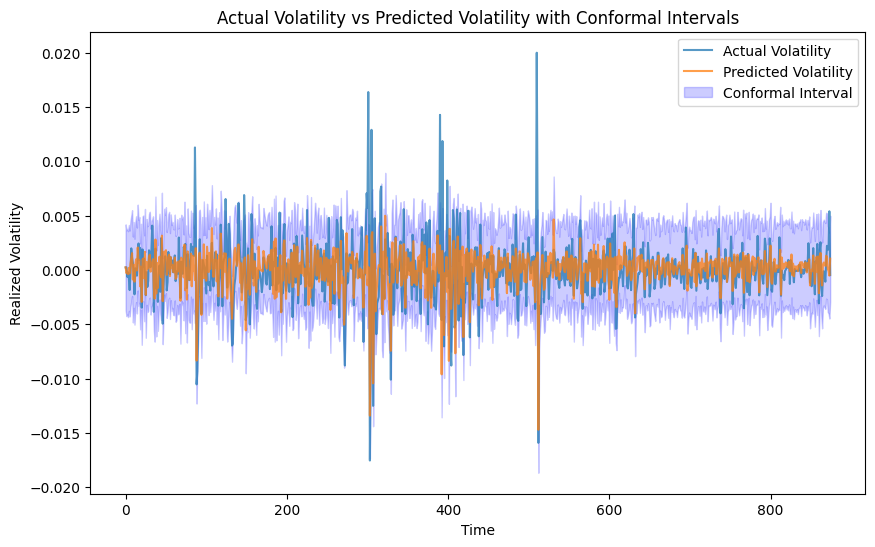

In [3]:

# Calculate conformal prediction intervals
q_conf = conformal_prediction_intervals(Lasso(alpha=0.001), X_sig_train, y_sig_train_component,scaler_y)
yhat_lower = yhat_test - q_conf
yhat_upper = yhat_test + q_conf
print(f"Real-space conformal quantile: {q_conf:.4f}")


# Plot 1: Actual Volatility vs Predicted Volatility with Conformal Intervals
plt.figure(figsize=(10, 6))
plt.plot(y_test_real, label='Actual Volatility', alpha=0.75)
plt.plot(yhat_test, label='Predicted Volatility', alpha=0.75)
plt.fill_between(np.arange(len(yhat_test)), yhat_lower, yhat_upper, color='blue', alpha=0.2, label='Conformal Interval')
plt.legend()
plt.title('Actual Volatility vs Predicted Volatility with Conformal Intervals')
plt.xlabel('Time')
plt.ylabel('Realized Volatility')
plt.show()


Feature 0:


/var/folders/42/y44rx7lj3l3_x781hgslxhhh0000gn/T/ipykernel_96739/132314231.py:53: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(


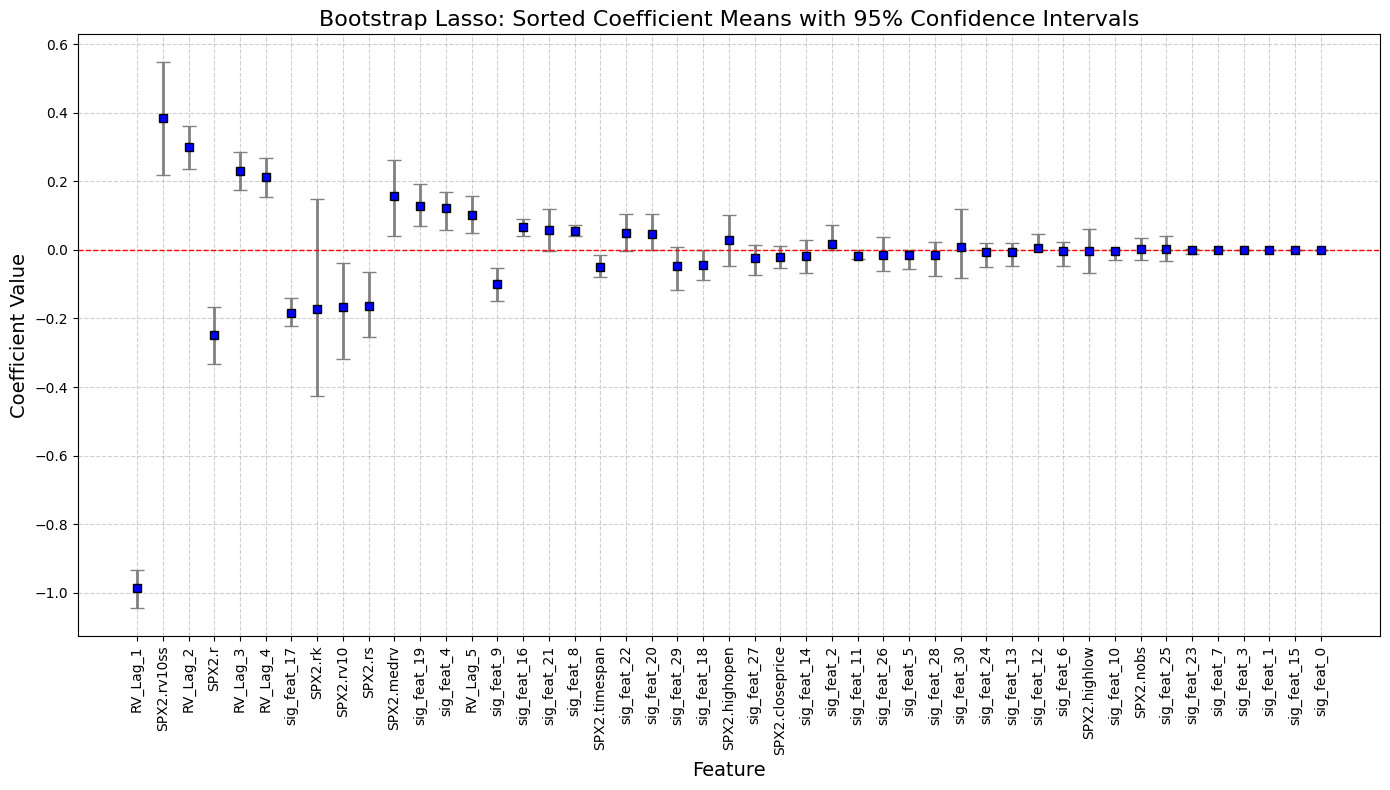

In [4]:
# Bootstrap Coefficients
coef_means, coef_stds, intercept_mean, intercept_std, coefs, intercepts, lower_bounds, upper_bounds = bootstrap_lasso(
    X_sig_train, y_sig_train_component.reshape(-1, 1)
)

for i in range(coef_means.shape[1]):  # Loop over target dimensions
    print(f"Feature {i}:")
    for j in range(coef_means.shape[0]):  # Loop over predictors
        mean = coef_means[j, i]
        lb = lower_bounds[j, i]
        ub = upper_bounds[j, i]
        #print(f"   Predictor {j}: Mean={mean:.4f}, 95% CI=({lb:.4f}, {ub:.4f})")



# ------------- Plotting-----------------


num_signature_features = coef_means.shape[0] - len(selected_features)

signature_feature_names = [f'sig_feat_{i}' for i in range(num_signature_features)]


# Get sizes
num_signature_features = coef_means.squeeze().shape[0] - len(selected_features)
signature_feature_names = [f'sig_feat_{i}' for i in range(num_signature_features)]
full_feature_names = signature_feature_names + selected_features.tolist()

# Squeeze arrays to 1D
coef_mean = coef_means.squeeze()
lower_bound = lower_bounds.squeeze()
upper_bound = upper_bounds.squeeze()

# Compute asymmetric error bars
lower_errors = coef_mean - lower_bound
upper_errors = upper_bound - coef_mean
error_bars = [lower_errors, upper_errors]

# Sorting by absolute coefficient size
sorted_indices = np.argsort(-np.abs(coef_mean))

coef_mean_sorted = coef_mean[sorted_indices]
error_bars_sorted = [np.array(error_bars[0])[sorted_indices], np.array(error_bars[1])[sorted_indices]]
feature_names_sorted = np.array(full_feature_names)[sorted_indices]
feature_indices = np.arange(len(coef_mean_sorted))


# Ensure all error bars are positive
error_bars_sorted = [np.abs(np.array(error_bars_sorted[0])), np.abs(np.array(error_bars_sorted[1]))]

# Plot
plt.figure(figsize=(14, 8))
plt.errorbar(
    feature_indices,
    coef_mean_sorted,
    yerr=error_bars_sorted,
    fmt='o',
    ecolor='gray',
    elinewidth=2,
    capsize=5,
    marker='s',
    markersize=6,
    markerfacecolor='blue',
    markeredgecolor='black',
    linestyle='none'
)

plt.axhline(0, color='red', linestyle='--', linewidth=1)

plt.xticks(feature_indices, feature_names_sorted, rotation=90, fontsize=10)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Coefficient Value', fontsize=14)
plt.title('Bootstrap Lasso: Sorted Coefficient Means with 95% Confidence Intervals', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()



--- Realized Volatility Distribution (ES Calibration Segments) ---
Mean of Realized_Volatility (ES Train Segment): 0.008868
Std Dev of Realized_Volatility (ES Train Segment): 0.004573
Mean of Realized_Volatility (ES Test Segment): 0.005541
Std Dev of Realized_Volatility (ES Test Segment): 0.003378

--- Scale-Dependent Metrics ---
MAE: 0.0014
MSE: 0.0000
RMSE: 0.0021


--- Forecast Bias Metrics ---
ME: 0.0000
CFE: 0.0011
MAD: 0.0014
TS: 0.8084


--- Percentage Error Metrics ---
MAPE: 215.3346%
WAPE: 76.7269%
sMAPE: 113.1250%
MAAPE: 0.7132%


--- Scale-Independent Metrics ---
MASE: 0.5974
RMSSE: 0.6380


--- Relative Accuracy Metric: Forecast Value Added (FVA) ---
FVA: 40.9714%




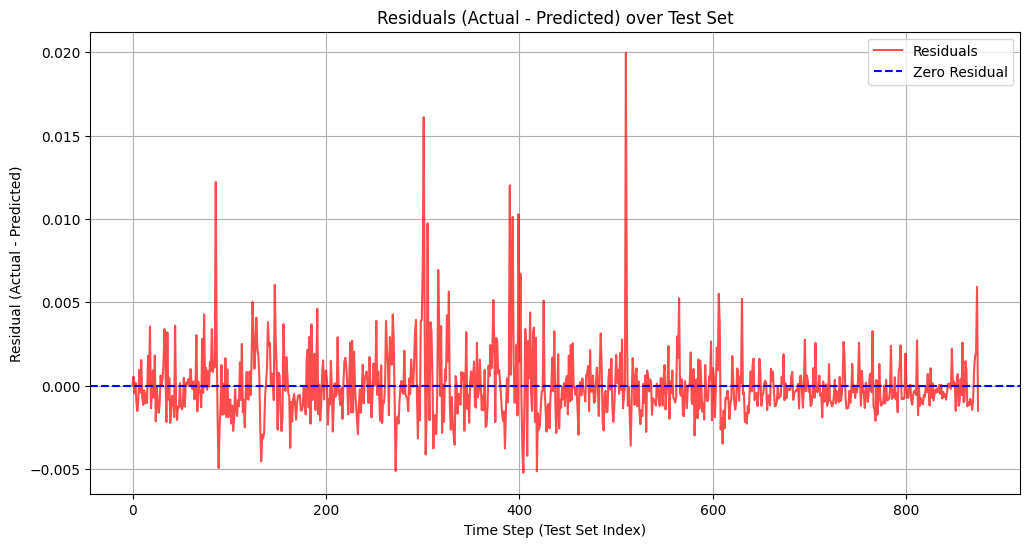

In [5]:

es_cal_data_segment = actual_data[p : len(actual_data) - q]
es_cal_train_segment = es_cal_data_segment[:train_size_es_cal]
es_cal_test_segment = es_cal_data_segment[train_size_es_cal:]

print(f"--- Realized Volatility Distribution (ES Calibration Segments) ---")
print(f"Mean of Realized_Volatility (ES Train Segment): {np.mean(es_cal_train_segment):.6f}")
print(f"Std Dev of Realized_Volatility (ES Train Segment): {np.std(es_cal_train_segment):.6f}")
print(f"Mean of Realized_Volatility (ES Test Segment): {np.mean(es_cal_test_segment):.6f}")
print(f"Std Dev of Realized_Volatility (ES Test Segment): {np.std(es_cal_test_segment):.6f}\n")

num_predictors = X_sig_train.shape[1]


# Error Metric Calculations

# 1. Scale-Dependent Metrics
scale_dependent_metrics = calculate_scale_dependent_metrics(y_test_exp, yhat_test)
print("--- Scale-Dependent Metrics ---")
for metric, value in scale_dependent_metrics.items():
    print(f'{metric}: {value:.4f}')
print("\n")

# 2. Forecast Bias Metrics
forecast_bias_metrics = calculate_forecast_bias_metrics(y_test_exp, yhat_test)
print("--- Forecast Bias Metrics ---")
for metric, value in forecast_bias_metrics.items():
    if isinstance(value, float):
        print(f'{metric}: {value:.4f}')
    else:
        print(f'{metric}: {value}')
print("\n")

# 3. Percentage Error Metrics
percentage_error_metrics = calculate_percentage_error_metrics(y_test_exp, yhat_test)
print("--- Percentage Error Metrics ---")
for metric, value in percentage_error_metrics.items():
    print(f'{metric}: {value:.4f}%')
print("\n")

# 4. Scale-Independent Metrics
# Calculate in-sample naive benchmark errors for scaling
# The training segment for ES_calibration corresponds to actual_data from index p to p + train_size_es_cal - 1.
naive_errors_for_scaling = calculate_naive_benchmark_errors(actual_data[p : p + train_size_es_cal])
scale_independent_metrics = calculate_scale_independent_metrics(y_test_exp, yhat_test, naive_errors_for_scaling)
print("--- Scale-Independent Metrics ---")
for metric, value in scale_independent_metrics.items():
    if isinstance(value, float):
        print(f'{metric}: {value:.4f}')
    else:
        print(f'{metric}: {value}')
print("\n")

# 5. Relative Accuracy Metric: Forecast Value Added (FVA)
# Naive benchmark errors for the test set
naive_errors_test = calculate_naive_benchmark_errors(y_test_exp)
fva_metric = calculate_fva(y_test_exp, yhat_test, naive_errors_test)
print("--- Relative Accuracy Metric: Forecast Value Added (FVA) ---")
for metric, value in fva_metric.items():
    if isinstance(value, float):
        print(f'{metric}: {value:.4f}%')
    else:
        print(f'{metric}: {value}')
print("\n")


# --- Plot of Residuals ---
plot_residuals(y_test_exp, yhat_test, title="Residuals (Actual - Predicted) over Test Set")




--- Applying Bias Correction ---
Correcting predictions by subtracting Mean Error: 0.000001

--- Performance Metrics (After Bias Correction) ---
--- Standard Performance Metrics (After Bias Correction) ---
RMSE: 0.0021
MSE: 0.0000
R2: 0.4289
Adjusted R2: 0.3964


--- Scale-Dependent Metrics (After Correction) ---
MAE: 0.0014
MSE: 0.0000
RMSE: 0.0021

--- Forecast Bias Metrics (After Correction) ---
ME: -0.0000
CFE: -0.0000
MAD: 0.0014
TS: -0.0000

--- Percentage Error Metrics (After Correction) ---
MAPE: 215.2633%
WAPE: 76.7135%
sMAPE: 113.1124%
MAAPE: 0.7131%

--- Scale-Independent Metrics (After Correction) ---
MASE: 0.5973
RMSSE: 0.6380

--- Relative Accuracy Metric: Forecast Value Added (FVA) (After Correction) ---
FVA: 40.9817%


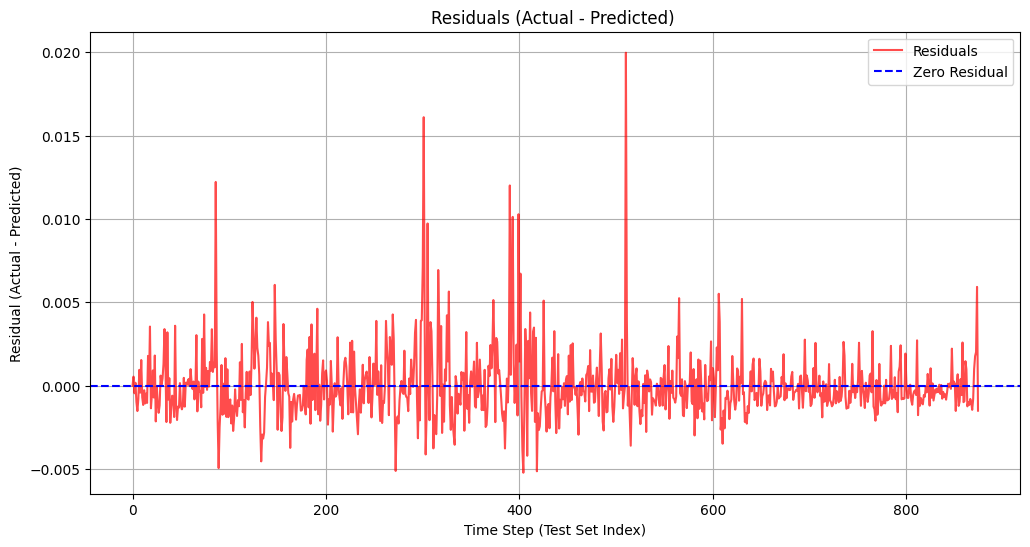

In [6]:


# --- Apply Bias Correction ---
# Get the Mean Error (ME) from the initial forecast bias metrics
mean_error_for_correction = forecast_bias_metrics['ME']
print(f"\n--- Applying Bias Correction ---")
print(f"Correcting predictions by subtracting Mean Error: {mean_error_for_correction:.6f}\n")

yhat_test_corrected = yhat_test - mean_error_for_correction

# --- Re-calculate and print metrics after bias correction ---
print(f"--- Performance Metrics (After Bias Correction) ---")

# Calculate common performance metrics for corrected predictions
rmse_corrected = np.sqrt(mean_squared_error(y_test_exp, yhat_test_corrected))
mse_corrected = mean_squared_error(y_test_exp, yhat_test_corrected)
r2_corrected = r2_score(y_test_exp, yhat_test)

adjusted_r2_corrected = np.nan
if (len(y_test_exp) - num_predictors - 1) > 0:
    adjusted_r2_corrected = 1 - (1 - r2_corrected) * ((len(y_test_exp) - 1) / (len(y_test_exp) - num_predictors - 1))

print(f"--- Standard Performance Metrics (After Bias Correction) ---")
print(f'RMSE: {rmse_corrected:.4f}')
print(f'MSE: {mse_corrected:.4f}')
print(f'R2: {r2_corrected:.4f}')
print(f'Adjusted R2: {adjusted_r2_corrected:.4f}\n')



# 1. Scale-Dependent Metrics (Corrected)
scale_dependent_metrics_corrected = calculate_scale_dependent_metrics(y_test_exp, yhat_test_corrected)
print("\n--- Scale-Dependent Metrics (After Correction) ---")
for metric, value in scale_dependent_metrics_corrected.items():
    print(f'{metric}: {value:.4f}')



# 2. Forecast Bias Metrics (Corrected)
forecast_bias_metrics_corrected = calculate_forecast_bias_metrics(y_test_exp, yhat_test_corrected)
print("\n--- Forecast Bias Metrics (After Correction) ---")
bias_metrics_to_plot_corrected = {k: v for k, v in forecast_bias_metrics_corrected.items() if isinstance(v, (int, float)) and not np.isnan(v)}
for metric, value in forecast_bias_metrics_corrected.items():
    if isinstance(value, float):
        print(f'{metric}: {value:.4f}')
    else:
        print(f'{metric}: {value}')



# 3. Percentage Error Metrics (Corrected)
percentage_error_metrics_corrected = calculate_percentage_error_metrics(y_test_exp, yhat_test_corrected)
print("\n--- Percentage Error Metrics (After Correction) ---")
for metric, value in percentage_error_metrics_corrected.items():
    print(f'{metric}: {value:.4f}%')



# 4. Scale-Independent Metrics (Corrected)
# Use the same naive_errors_for_scaling as it's based on the training data
scale_independent_metrics_corrected = calculate_scale_independent_metrics(y_test_exp, yhat_test_corrected, naive_errors_for_scaling)
print("\n--- Scale-Independent Metrics (After Correction) ---")
independent_metrics_to_plot_corrected = {k: v for k, v in scale_independent_metrics_corrected.items() if isinstance(v, (int, float)) and not np.isnan(v)}
for metric, value in independent_metrics_to_plot_corrected.items():
    if isinstance(value, float):
        print(f'{metric}: {value:.4f}')
    else:
        print(f'{metric}: {value}')



# 5. Relative Accuracy Metric: Forecast Value Added (FVA) (Corrected)
# Use the same naive_errors_test as it's based on the actual test data
fva_metric_corrected = calculate_fva(y_test_exp, yhat_test_corrected, naive_errors_test)
print("\n--- Relative Accuracy Metric: Forecast Value Added (FVA) (After Correction) ---")
fva_to_plot_corrected = {k: v for k, v in fva_metric_corrected.items() if isinstance(v, (int, float)) and not np.isnan(v)}
for metric, value in fva_to_plot_corrected.items():
    if isinstance(value, float):
        print(f'{metric}: {value:.4f}%')
    else:
        print(f'{metric}: {value}')



# --- Plot of Corrected Residuals ---
plot_residuals(y_test_exp, yhat_test_corrected, title="Residuals (Actual - Predicted) ")





Original number of observations: 4683

--- Outlier Removal Comparison ---
  Z_SCORE (Threshold=3): Removed 288 observations (6.15%)
  Z_SCORE (Threshold=2.5): Removed 326 observations (6.96%)
  Z_SCORE (Threshold=3.5): Removed 262 observations (5.59%)
  MAD (Threshold=3 on Z-score equivalent): Removed 462 observations (9.87%)

Final number of observations after Z-score (threshold=3) outlier removal: 4395


/var/folders/42/y44rx7lj3l3_x781hgslxhhh0000gn/T/ipykernel_96739/2996298744.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Realized_Volatility'] = np.sqrt(df['SPX2.rv'])


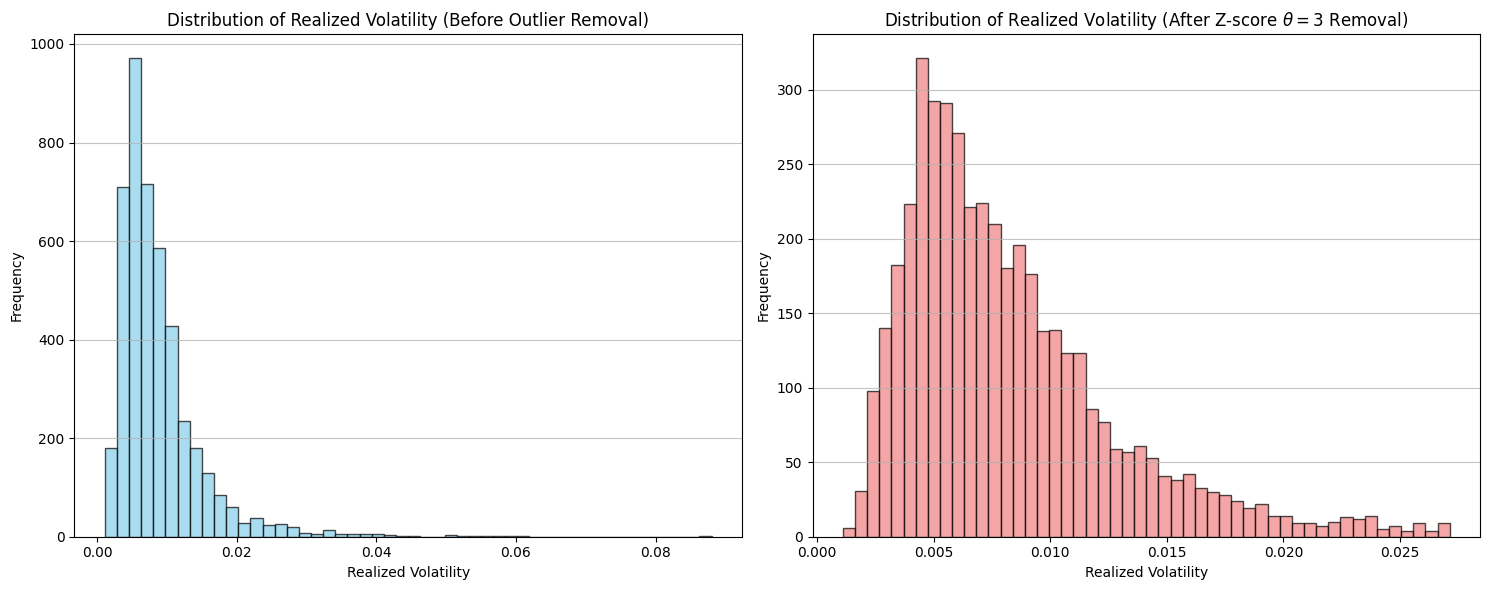

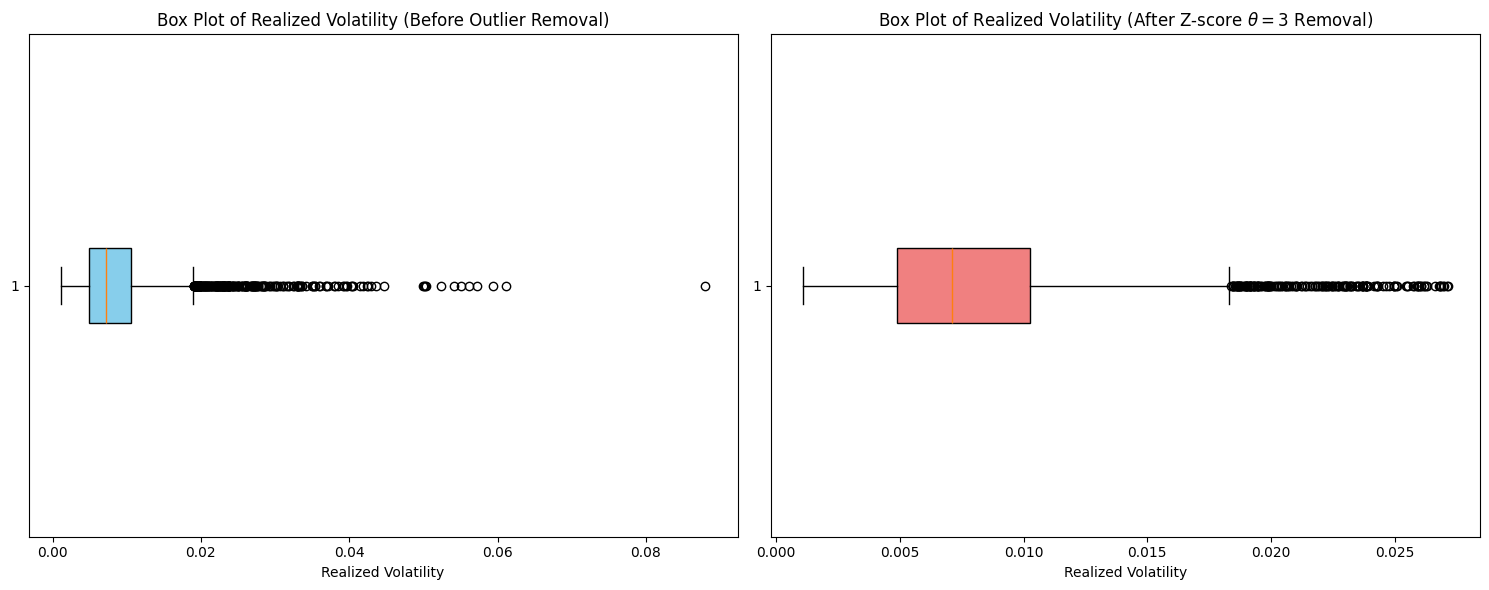

In [7]:
# Load and process data
df = pd.read_csv('old_OxfordManRealizedVolatilityIndices.csv', sep=",", header=2)
df_filtered = df.filter(regex='^SPX|^Date')
df_filtered['Realized_Volatility'] = np.sqrt(df['SPX2.rv'])
df2 = df_filtered.copy()
df2['DateID'] = pd.to_datetime(df2['DateID'], format='%Y%m%d')

# --- Outlier Removal Analysis ---

# Store original number of observations
original_observations = len(df2)
print(f"Original number of observations: {original_observations}")

# Function to remove outliers based on Z-score or MAD
def remove_outliers_and_report(data, column, method='z_score', threshold=3):
    initial_len = len(data)
    if method == 'z_score':
        mean_val = data[column].mean()
        std_dev = data[column].std()
        z_scores = np.abs((data[column] - mean_val) / std_dev)
        # Filter out NaNs if they exist in z_scores
        filtered_data = data[~z_scores.isna() & (z_scores < threshold)].copy()
        removed_count = initial_len - len(filtered_data)
        removed_percentage = (removed_count / initial_len) * 100
        print(f"  {method.upper()} (Threshold={threshold}): Removed {removed_count} observations ({removed_percentage:.2f}%)")
    elif method == 'mad':
        # Create a temporary series without NaNs for robust MAD calculation
        temp_series = data[column].dropna()

        if temp_series.empty:
            print(f"  MAD method: Column '{column}' contains only NaN values or is empty after dropping NaNs. No outliers can be determined.")
            return data.copy()

        median_val = temp_series.median()
        mad_val = np.median(np.abs(temp_series - median_val))

        if mad_val == 0:
            print(f"  MAD method: All non-NaN values are identical, MAD is 0. No outliers removed.")
            # If MAD is 0, no variability, no outliers relative to median, return original data
            return data.copy()

        # Calculate MAD Z-scores for the *original* column (which might contain NaNs)
        # NaNs in the original column will result in NaNs in mad_z_scores.
        mad_z_scores = np.abs((data[column] - median_val) / (mad_val * 1.4826))

        # Filter the original DataFrame based on the computed MAD Z-scores.
        # Keep rows where mad_z_scores are NOT NaN AND are less than the threshold.
        # This will also implicitly remove rows that had NaN in 'Realized_Volatility'
        # if the mad_z_scores for those were NaN.
        filtered_data = data[~mad_z_scores.isna() & (mad_z_scores < threshold)].copy()

        removed_count = initial_len - len(filtered_data)
        removed_percentage = (removed_count / initial_len) * 100
        print(f"  {method.upper()} (Threshold={threshold} on Z-score equivalent): Removed {removed_count} observations ({removed_percentage:.2f}%)")
    else:
        raise ValueError("Method must be 'z_score' or 'mad'")
    return filtered_data


print("\n--- Outlier Removal Comparison ---")
# Apply Z-score outlier removal with different thresholds
df2_z_3 = remove_outliers_and_report(df2, 'Realized_Volatility', method='z_score', threshold=3)
df2_z_2_5 = remove_outliers_and_report(df2, 'Realized_Volatility', method='z_score', threshold=2.5)
df2_z_3_5 = remove_outliers_and_report(df2, 'Realized_Volatility', method='z_score', threshold=3.5)

# Apply MAD outlier removal (using a standard threshold, e.g., 3 for Z-score equivalent)
df2_mad_3 = remove_outliers_and_report(df2, 'Realized_Volatility', method='mad', threshold=3)

# Use the original Z-score (threshold=3) filtered data for the rest of the script
# IMPORTANT: Reset df2 to the Z-score filtered version for consistency with original script flow
df2 = df2_z_3.copy()

print(f"\nFinal number of observations after Z-score (threshold=3) outlier removal: {len(df2)}")




# --- Visualization of Outlier Removal ---
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.hist(df_filtered['Realized_Volatility'].dropna(), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Realized Volatility (Before Outlier Removal)')
plt.xlabel('Realized Volatility')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)


plt.subplot(1, 2, 2)
plt.hist(df2['Realized_Volatility'].dropna(), bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
plt.title('Distribution of Realized Volatility (After Z-score $\\theta=3$ Removal)')
plt.xlabel('Realized Volatility')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)


plt.tight_layout()
plt.show()

# Optional: Box plots to show outliers
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.boxplot(df_filtered['Realized_Volatility'].dropna(), vert=False, patch_artist=True, boxprops=dict(facecolor='skyblue'))
plt.title('Box Plot of Realized Volatility (Before Outlier Removal)')
plt.xlabel('Realized Volatility')

plt.subplot(1, 2, 2)
plt.boxplot(df2['Realized_Volatility'].dropna(), vert=False, patch_artist=True, boxprops=dict(facecolor='lightcoral'))
plt.title('Box Plot of Realized Volatility (After Z-score $\\theta=3$ Removal)')
plt.xlabel('Realized Volatility')

plt.tight_layout()
plt.show()

/var/folders/42/y44rx7lj3l3_x781hgslxhhh0000gn/T/ipykernel_96739/2581944197.py:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Realized_Volatility'] = np.sqrt(df['SPX2.rv'])
/opt/homebrew/Cellar/jupyterlab/4.3.5/libexec/lib/python3.13/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['SPX2.rcto']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Lasso-selected features (from full candidate set): ['SPX2.rk', 'SPX2.r', 'SPX2.rv10', 'SPX2.rv10ss', 'SPX2.medrv', 'SPX2.rs', 'SPX2.nobs', 'SPX2.timespan', 'SPX2.highlow', 'SPX2.highopen', 'SPX2.closeprice', 'RV_Lag_1', 'RV_Lag_2', 'RV_Lag_3', 'RV_Lag_4', 'RV_Lag_5']

--- Calculating R^2 for different scenarios ---

Scenario (i): Lags + Signature (as implemented by 'Lags Only' via ES_calibration)
R^2 for Lags + Signature (Scenario i): 0.1372


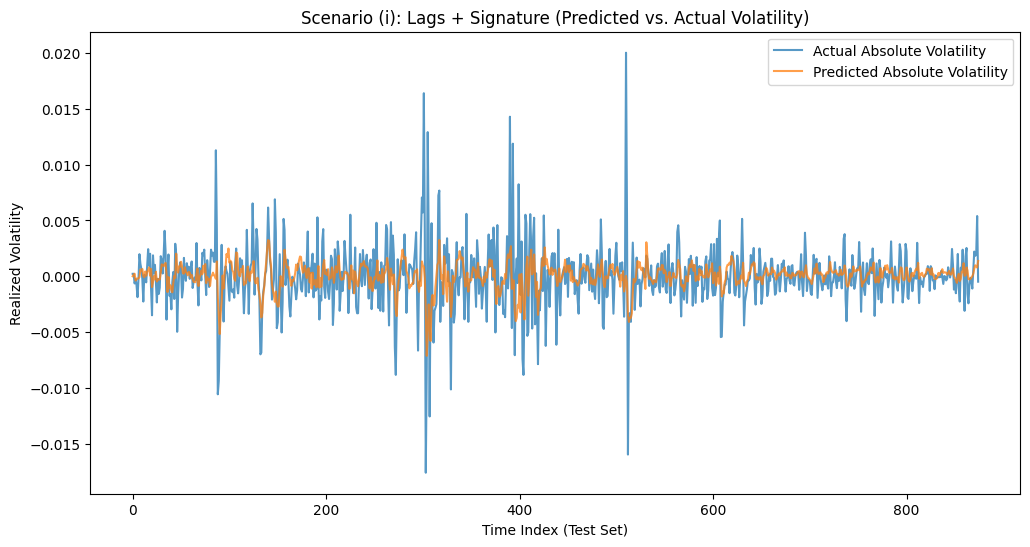


Scenario (ii): Signature Only (ES Calibration)
R^2 for Signature Only (Scenario ii): 0.1384


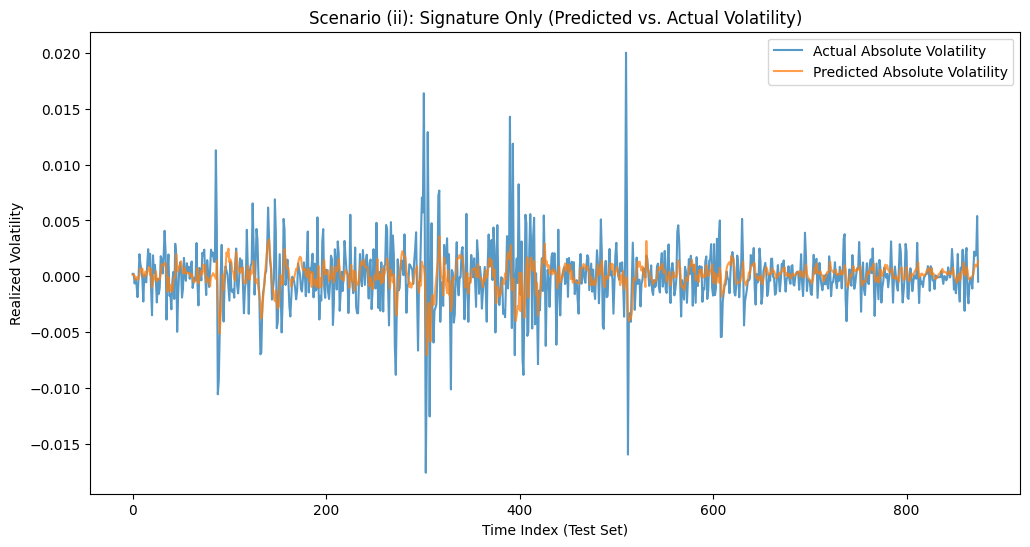


Scenario (iii): Other Features + Signature (via ES Calibration)


/opt/homebrew/Cellar/jupyterlab/4.3.5/libexec/lib/python3.13/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [43]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.3.5/libexec/lib/python3.13/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [43]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


R^2 for Other Features + Signature (Scenario iii): 0.4333


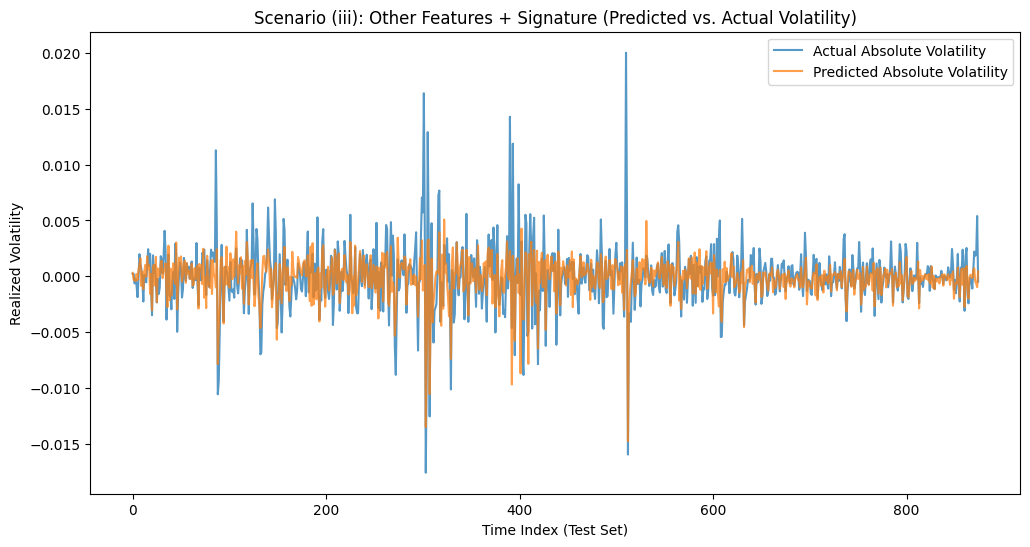


Scenario (iv): Full Lasso-Selected Feature Set + Signature (via ES Calibration)


/opt/homebrew/Cellar/jupyterlab/4.3.5/libexec/lib/python3.13/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [43]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.3.5/libexec/lib/python3.13/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [43]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


R^2 for Full Lasso-Selected Features + Signature (Scenario iv): 0.4333


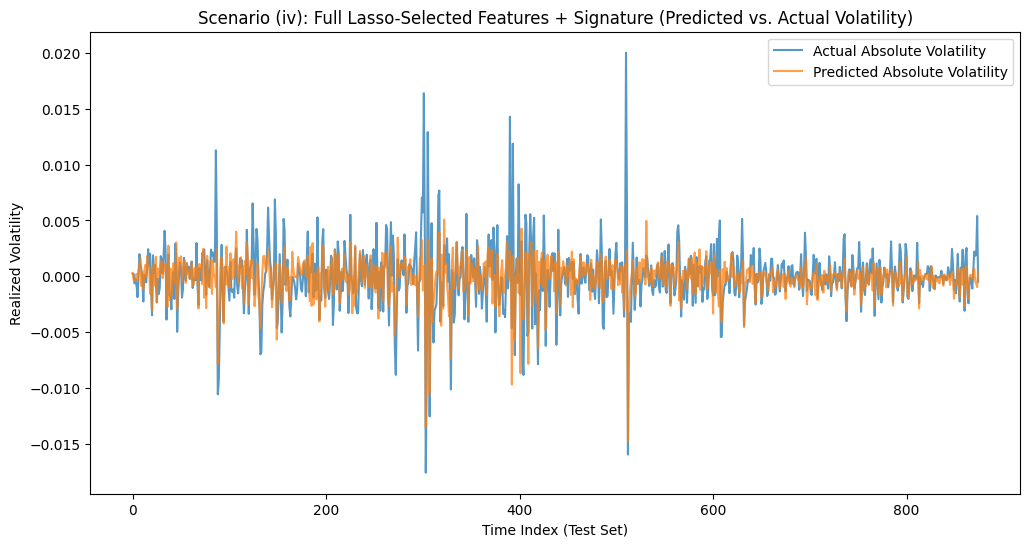


--- Summary of R^2 Values ---
Lags + Signature (Scenario i): 0.1372
Signature Only (Scenario ii): 0.1384
Other Features + Signature (Scenario iii): 0.4333
Full Lasso-Selected Features + Signature (Scenario iv): 0.4333


In [8]:
import pandas as pd
import numpy as np
import time
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from esig import tosig
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.multioutput import MultiOutputRegressor
from sklearn.impute import SimpleImputer

# Suppress convergence warnings from Lasso
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# --- Signature Computation ---
def compute_signature(path, order):
    """
    Computes the signature of a given path up to a specified order.

    Args:
        path (np.ndarray): The input path, typically a 2D array where rows are
                           points and columns are dimensions (e.g., [time, value]).
        order (int): The maximum signature order to compute.

    Returns:
        np.ndarray: The signature of the path as a 1D numpy array.
    """
    return tosig.stream2sig(path, order)

import pandas as pd
import numpy as np
import time
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from esig import tosig
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.multioutput import MultiOutputRegressor
from sklearn.impute import SimpleImputer

# Suppress convergence warnings from Lasso
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# --- Signature Computation ---
def compute_signature(path, order):
    """
    Computes the signature of a given path up to a specified order.

    Args:
        path (np.ndarray): The input path, typically a 2D array where rows are
                           points and columns are dimensions (e.g., [time, value]).
        order (int): The maximum signature order to compute.

    Returns:
        np.ndarray: The signature of the path as a 1D numpy array.
    """
    return tosig.stream2sig(path, order)

def ES_calibration(data, expected_data, p, q, n, m, demean=True, additional_features=None):
    """
    Performs Event-Series (ES) calibration by computing signatures of past and future
    paths and training a Lasso model to predict future signatures from past ones.

    Args:
        data (np.ndarray): The main time series data.
        expected_data (np.ndarray): The expected future data (shifted main data).
        p (int): Length of the past path window.
        q (int): Length of the future path window (typically 1 for next step).
        n (int): Signature depth for past paths.
        m (int): Signature depth for future paths.
        demean (bool): Whether to demean the paths by their base value.
        additional_features (pd.DataFrame, optional): Additional features to concatenate
                                                     with the past signature.

    Returns:
        tuple: A tuple containing:
            - y_test_real (np.ndarray): Actual future values for testing.
            - y_test_exp (np.ndarray): Expected future values for testing.
            - yhat_test (np.ndarray): Predicted future values for testing.
            - running_time (float): Time taken for the calibration process.
            - X_sig_train (np.ndarray): Scaled past signatures for training.
            - y_sig_train_component (np.ndarray): Scaled 3rd component of future signatures for training.
            - lasso (MultiOutputRegressor): The trained Lasso model.
            - X_sig_test (np.ndarray): Scaled past signatures for testing.
            - scaler_y (StandardScaler): The scaler fitted on future signatures.
            - train_size_es (int): The size of the training set used for ES calibration.
    """
    starting_time = time.time()

    X_sig, y_sig = [], []

    # Iterate through the data to create past and future path windows
    for t in range(p, len(data) - q):
        base_value = data[t - 1]

        # --- Constructing Past path ---
        past_values = data[t - p: t + 1]
        if demean:
            past_values = past_values - base_value
        else:
            past_values = np.insert(past_values, 0, 0)
        
        time_steps = np.linspace(0, 1, len(past_values))
        past_path = np.column_stack((time_steps, past_values))

        past_path_with_time = []
        for i in range(len(past_path) - 1):
            start_time, start_value = past_path[i]
            end_time, _ = past_path[i + 1]
            past_path_with_time.append([start_time, start_value])
            past_path_with_time.append([end_time, start_value])
        past_path_with_time.append(past_path[-1].tolist())
        past_path_with_time = np.array(past_path_with_time)

        past_signature = compute_signature(past_path_with_time, n)

        # --- Constructing Future path ---
        future_values = np.array([0, data[t] - base_value, data[t + 1] - base_value])
        future_times = np.linspace(0, 1, len(future_values))
        future_path = np.column_stack((future_times, future_values))

        future_path_with_time = []
        for i in range(len(future_path) - 1):
            start_time, start_value = future_path[i]
            end_time, _ = future_path[i + 1]
            future_path_with_time.append([start_time, start_value])
            future_path_with_time.append([end_time, start_value])
        future_path_with_time.append(future_path[-1].tolist())
        future_path_with_time = np.array(future_path_with_time)

        future_signature = compute_signature(future_path_with_time, m)

        # --- Add additional features if provided ---
        if additional_features is not None:
            extra_feat = additional_features.iloc[t - p].values
            past_signature = np.concatenate((past_signature, extra_feat))

        X_sig.append(past_signature)
        y_sig.append(future_signature)

    X_sig = np.array(X_sig)
    y_sig = np.array(y_sig)

    # --- Data Splitting ---
    train_size_es = int(0.8 * len(X_sig)) # Store this for naive benchmark
    X_sig_train_raw, y_sig_train_raw = X_sig[:train_size_es], y_sig[:train_size_es]
    X_sig_test_raw, y_sig_test_raw = X_sig[train_size_es:], y_sig[train_size_es:]

    # --- Imputation ---
    imputer_X = SimpleImputer(strategy='mean')
    X_sig_train = imputer_X.fit_transform(X_sig_train_raw)
    X_sig_test = imputer_X.transform(X_sig_test_raw) 

    # --- Scaling ---
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    
    X_sig_train = scaler_x.fit_transform(X_sig_train)
    y_sig_train = scaler_y.fit_transform(y_sig_train_raw)

    X_sig_test = scaler_x.transform(X_sig_test)
    y_sig_test = scaler_y.transform(y_sig_test_raw) 

    # --- Model Training ---
    lasso = MultiOutputRegressor(Lasso(alpha=0.001, random_state=42)) 
    lasso.fit(X_sig_train, y_sig_train)

    # --- Prediction ---
    yhat_sig_test = lasso.predict(X_sig_test)

    # --- Inverse Transformation for Evaluation ---
    yhat_test = scaler_y.inverse_transform(yhat_sig_test)[:, 2]  
    y_test_exp = scaler_y.inverse_transform(y_sig_test)[:, 2]  
    y_test_real = scaler_y.inverse_transform(y_sig_test)[:, 2]

    ending_time = time.time()
    running_time = ending_time - starting_time

    return y_test_real, y_test_exp, yhat_test, running_time, X_sig_train, y_sig_train[:, 2], lasso, X_sig_test, scaler_y, train_size_es

# --- Main Script Execution ---

# Load and process data
df = pd.read_csv('old_OxfordManRealizedVolatilityIndices.csv', sep=",", header=2)
df_filtered = df.filter(regex='^SPX|^Date')
df_filtered['Realized_Volatility'] = np.sqrt(df['SPX2.rv'])
df2 = df_filtered.copy()
df2['DateID'] = pd.to_datetime(df2['DateID'], format='%Y%m%d')

# Remove outliers
def remove_outliers(data, column, threshold=3):
    z_scores = np.abs((data[column] - data[column].mean()) / data[column].std())
    return data[z_scores < threshold]
df2 = remove_outliers(df2, 'Realized_Volatility')

# Create lag features for 'Realized_Volatility'
lag_cols = [f'RV_Lag_{lag}' for lag in range(1, 6)]
for lag in range(1, 6):
    df2[f'RV_Lag_{lag}'] = df2['Realized_Volatility'].shift(lag)



# Prepare data for modeling
# Full set of candidate features for Lasso feature selection (including lags)
full_candidate_features = [
    'SPX2.rk', 'SPX2.r', 'SPX2.rv5ss', 'SPX2.rv10', 'SPX2.rv10ss',
    'SPX2.bv5', 'SPX2.bv5ss', 'SPX2.medrv', 'SPX2.rs', 'SPX2.rs5ss',
    'SPX2.nobs', 'SPX2.timespan', 'SPX2.rcto', 'SPX2.open',
    'SPX2.highlow', 'SPX2.highopen', 'SPX2.openprice', 'SPX2.closeprice'
] +lag_cols
X_full_original = df2[full_candidate_features]
y_original = df2['Realized_Volatility']

# Time-series split for initial LassoCV feature selection
train_size_fs = int(0.8 * len(X_full_original))
X_train_feat_full = X_full_original.iloc[:train_size_fs]
y_train_feat_full = y_original.iloc[:train_size_fs]

# Impute and scale training features only for LassoCV
imputer_fs = SimpleImputer(strategy='mean')
X_train_imp_full = imputer_fs.fit_transform(X_train_feat_full)

scaler_fs = StandardScaler()
X_train_scaled_full = scaler_fs.fit_transform(X_train_imp_full)

# LassoCV on training set only to determine selected features
lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_train_scaled_full, y_train_feat_full)

# Get selected features from the training set
selected_features_mask = lasso_cv.coef_ != 0
valid_columns_fs = X_full_original.columns[~np.isnan(imputer_fs.statistics_)]
selected_features = valid_columns_fs[selected_features_mask].tolist()
print(f"Lasso-selected features (from full candidate set): {selected_features}")


X_reduced = X_full_original[full_candidate_features]



actual_data_for_es_cal = y_original.values
expected_data_for_es_cal = y_original.shift(-1).values
# --------------------------------------------------------------------------
# Scenarios for Incremental R^2 Calculation
# --------------------------------------------------------------------------

# Define parameters for ES calibration
p = 20  # Length of the past path window
q = 1   # Length of the future path window (predict next day's volatility)
n = 4   # Signature depth for past data
m = 3   # Signature depth for future data

results = {}

X_reduced_aligned = X_reduced.iloc[p: len(actual_data_for_es_cal) - q]  # must match X_sig length


print("\n--- Calculating R^2 for different scenarios ---")

# (i) Lags + Signature (Implementation of "Lags Only" via ES_calibration)
print("\nScenario (i): Lags + Signature (as implemented by 'Lags Only' via ES_calibration)")
# X_lags_for_es_cal includes the actual lagged features for ES_calibration to use
X_lags_for_es_cal = df2[lag_cols]
y_true_i, y_test_exp_i, yhat_pred_i, run_time_i, _, _, _, _, _, _ = ES_calibration(
    actual_data_for_es_cal, expected_data_for_es_cal, p, q, n, m, demean=True, additional_features=X_lags_for_es_cal
)
r2_lags = r2_score(y_test_exp_i, yhat_pred_i) # R2 calculated with relative actual vs absolute predicted
print(f"R^2 for Lags + Signature (Scenario i): {r2_lags:.4f}")
results['Lags + Signature (Scenario i)'] = r2_lags

# Plotting for Scenario (i)
plt.figure(figsize=(12, 6))
plt.plot(y_true_i, label='Actual Absolute Volatility', alpha=0.75)
plt.plot(yhat_pred_i, label='Predicted Absolute Volatility', alpha=0.75)
plt.title('Scenario (i): Lags + Signature (Predicted vs. Actual Volatility)')
plt.xlabel('Time Index (Test Set)')
plt.ylabel('Realized Volatility')
plt.legend()
plt.show()


# (ii) Signature Only (ES Calibration)
print("\nScenario (ii): Signature Only (ES Calibration)")
y_true_ii, y_test_exp_ii, yhat_pred_ii, run_time_ii, _, _, _, _, _, _ = ES_calibration(
    actual_data_for_es_cal, expected_data_for_es_cal, p, q, n, m, demean=True, additional_features=None
)
r2_sig_only = r2_score(y_test_exp_ii, yhat_pred_ii) # R2 calculated with relative actual vs absolute predicted
print(f"R^2 for Signature Only (Scenario ii): {r2_sig_only:.4f}")
results['Signature Only (Scenario ii)'] = r2_sig_only

# Plotting for Scenario (ii)
plt.figure(figsize=(12, 6))
plt.plot(y_true_ii, label='Actual Absolute Volatility', alpha=0.75)
plt.plot(yhat_pred_ii, label='Predicted Absolute Volatility', alpha=0.75)
plt.title('Scenario (ii): Signature Only (Predicted vs. Actual Volatility)')
plt.xlabel('Time Index (Test Set)')
plt.ylabel('Realized Volatility')
plt.legend()
plt.show()



# (iii) Other Features + Signature (via ES Calibration)
print("\nScenario (iii): Other Features + Signature (via ES Calibration)")
# additional_features=X_reduced_aligned, where X_reduced_aligned contains full_candidate_features (non-lags)
y_true_iii, y_test_exp_iii, yhat_pred_iii, run_time_iii, _, _, _, _, _, _ = ES_calibration(
    actual_data_for_es_cal, expected_data_for_es_cal, p, q, n, m, demean=True, additional_features=X_reduced_aligned
)
r2_lags_sig = r2_score(y_test_exp_iii, yhat_pred_iii) # R2 calculated with relative actual vs absolute predicted
print(f"R^2 for Other Features + Signature (Scenario iii): {r2_lags_sig:.4f}")
results['Other Features + Signature (Scenario iii)'] = r2_lags_sig

# Plotting for Scenario (iii)
plt.figure(figsize=(12, 6))
plt.plot(y_true_iii, label='Actual Absolute Volatility', alpha=0.75)
plt.plot(yhat_pred_iii, label='Predicted Absolute Volatility', alpha=0.75)
plt.title('Scenario (iii): Other Features + Signature (Predicted vs. Actual Volatility)')
plt.xlabel('Time Index (Test Set)')
plt.ylabel('Realized Volatility')
plt.legend()
plt.show()

# (iv) Full Lasso-Selected Feature Set + Signature (via ES Calibration)
print("\nScenario (iv): Full Lasso-Selected Feature Set + Signature (via ES Calibration)")
# This scenario also calls ES_calibration with X_reduced_aligned, making it functionally identical to (iii)
y_true_iv, y_test_exp_iv, yhat_pred_iv, run_time_iv, _, _, _, _, _, _ = ES_calibration(
    actual_data_for_es_cal, expected_data_for_es_cal, p, q, n, m, demean=True, additional_features=X_reduced_aligned
)
r2_full = r2_score(y_test_exp_iv, yhat_pred_iv) # R2 calculated with relative actual vs absolute predicted
print(f"R^2 for Full Lasso-Selected Features + Signature (Scenario iv): {r2_full:.4f}")
results['Full Lasso-Selected Features + Signature (Scenario iv)'] = r2_full

# Plotting for Scenario (iv) - identical to Scenario (iii) due to code implementation
plt.figure(figsize=(12, 6))
plt.plot(y_true_iv, label='Actual Absolute Volatility', alpha=0.75)
plt.plot(yhat_pred_iv, label='Predicted Absolute Volatility', alpha=0.75)
plt.title('Scenario (iv): Full Lasso-Selected Features + Signature (Predicted vs. Actual Volatility)')
plt.xlabel('Time Index (Test Set)')
plt.ylabel('Realized Volatility')
plt.legend()
plt.show()




print("\n--- Summary of R^2 Values ---")
for scenario, r2_val in results.items():
    print(f"{scenario}: {r2_val:.4f}")